# gWOT example

The following is a brief example of using the gWOT package to infer laws on paths from time-series observations of a diffusion-drift process with branching.


In [1]:
pip install gwot pot pykeops pathos

In [2]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import models, sim, ts, util
import gwot.bridgesampling as bs

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [4]:
# setup simulation parameters
dim = 4 # dimension of simulation
sim_steps = 1000 # number of steps to use for Euler-Maruyama method
T = 50 # number of timepoints
N = 20 # number of particles per timepoint
D = 0.25 # diffusivity
t_final = 0.75 # simulation run on [0, t_final]

In [5]:
# setup potential function
def Psi(x, t, dim = dim):
    x0 = 1.15*np.array([1, 1] + [0, ]*(dim - 2))
    x1 = -np.array([1, 1] + [0, ]*(dim - 2))
    return np.sum((x - x0)*(x - x0), axis = -1) * np.sum((x - x1)*(x - x1), axis = -1)
# get gradient 
dPsi = autograd.elementwise_grad(Psi)

In [6]:
# branching rates
beta = lambda x, t: 5*((np.tanh(2*x[0]) + 1)/2)
delta = lambda x, t: 0

# function for particle initialisation
ic_func = lambda N, d: np.random.randn(N, d)*0.1

# setup simulation object
sim = gwot.sim.Simulation(V = Psi, dV = dPsi, birth_death = True, 
                          birth = beta, 
                          death = delta,
                          N = np.repeat(N, T), 
                          T = T, 
                          d = dim, 
                          D = D, 
                          t_final = t_final, 
                          ic_func = ic_func, 
                          pool = None)

# sample from simulation
sim.sample(steps_scale = int(sim_steps/sim.T), trunc = N);

Text(0, 0.5, 'dim 1')

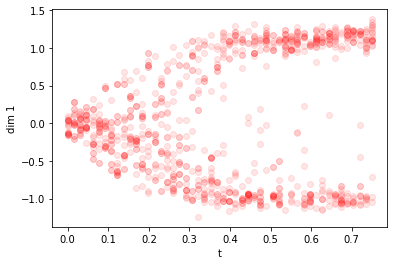

In [7]:
# plot samples
plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(N)), sim.x[:, 0], alpha = 0.1, color = "red")
plt.xlabel("t"); plt.ylabel("dim 1")

In [8]:
# set up gWOT model
# no a priori estimate on the branching (g = 1)
lamda = 0.00215
eps_df = 0.025
model_nullgrowth = gwot.models.OTModel(sim, lamda = lamda,
          eps_df = eps_df*torch.ones(sim.T).cuda(), 
          lamda_i = torch.ones(sim.T).cuda(), 
          m_i = torch.ones(sim.T).cuda(), 
          g_i = torch.ones(sim.T, sim.x.shape[0]).cuda(),
          kappa = None, 
          c_scale = torch.ones(sim.T).cuda(),
          c_scale_df = torch.ones(sim.T).cuda(),
          growth_constraint="exact", 
          pi_0 = "uniform",
          use_keops = True,
          device = device)

Compiling libKeOpstorch08d3a58821 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: Sum_Reduction(Exp(Minus(Sum((Square((Var(0,4,1) - Var(1,4,0))) / Var(2,1,2))))),0)
       aliases: Var(0,4,1); Var(1,4,0); Var(2,1,2); 
       dtype  : float64
... Done.


In [9]:
# construct branching rate estimate
g = lambda x: [beta(x[i, :], 0) - delta(x[i, :], 0) for i in range(x.shape[0])]
g_i = (sim.dt[0]*torch.tensor(g(sim.x))).repeat(sim.T, 1).exp()
m_i = np.power(g_i.mean(), np.arange(0, sim.T))
# set up gWOT model with a priori estimates
model_growth = gwot.models.OTModel(sim, lamda = lamda,
          eps_df = eps_df*torch.ones(sim.T).cuda(), 
          lamda_i = torch.ones(sim.T).cuda(), 
          m_i = m_i.cuda(), 
          g_i = g_i.cuda(),
          kappa = None, 
          c_scale = torch.ones(sim.T).cuda(),
          c_scale_df = torch.ones(sim.T).cuda(),
          growth_constraint="exact", 
          pi_0 = "uniform",
          use_keops = True,
          device = device)

In [10]:
# solve both gWOT models using L-BFGS
for m in [model_nullgrowth, model_growth]:
  m.solve_lbfgs(steps = 25, 
                max_iter = 50, 
                lr = 1, 
                history_size = 50, 
                line_search_fn = 'strong_wolfe', 
                factor = 2, 
                tol = 1e-5, 
                retry_max = 0)

Compiling libKeOpstorch7b6b9a6342 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: Max_SumShiftExpWeight_Reduction(Var(0,1,1),0,(Exp(Minus(Sum((Square((Var(1,4,1) - Var(2,4,0))) / Var(3,1,2))))) * Var(4,1,0)))
       aliases: Var(0,1,1); Var(1,4,1); Var(2,4,0); Var(3,1,2); Var(4,1,0); 
       dtype  : float64
... Done.
Compiling libKeOpstorch266b21fa70 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: Max_SumShiftExpWeight_Reduction(Var(0,1,1),0,(Var(1,1,0) * (Exp(Minus(Sum((Square((Var(2,4,1) - Var(3,4,0))) / Var(4,1,2))))) * Var(5,1,0))))
       aliases: Var(0,1,1); Var(1,1,0); Var(2,4,1); Var(3,4,0); Var(4,1,2); Var(5,1,0); 
       dtype  : float64
... Done.
Compiling libKeOpstorch1ac2785a64 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: Max_SumShiftExpWeight_Reduction(Var(0,1,1),0,Var(1,1,1))
       aliases: Var(0,1,1); Var(1,1,1); 
       dtype  : float64
... Done.
Compiling libKeOpstorchfff0a50a13 in /root/.cache/pykeops-1.4.2-cpython-36:
       formul

In [11]:
# sample paths
N_paths = 250
with torch.no_grad():
    paths_nullgrowth = bs.sample_paths(None, N = N_paths, coord = True, x_all = [sim.x, ]*sim.T, 
                        get_gamma_fn = lambda i : model_nullgrowth.get_coupling_spine(i, K = model_nullgrowth.get_K(i)).cpu(), num_couplings = sim.T-1)
    paths_growth = bs.sample_paths(None, N = N_paths, coord = True, x_all = [sim.x, ]*sim.T, 
                        get_gamma_fn = lambda i : model_growth.get_coupling_spine(i, K = model_growth.get_K(i)).cpu(), num_couplings = sim.T-1)


In [12]:
# sample ground truth paths
# sampling trajectories from Simulation object ignores the branching
paths_gt = sim.sample_trajectory(steps_scale = int(sim_steps/sim.T), N = N_paths)

Text(0.5, 1.0, '$\\beta_0 = 5$')

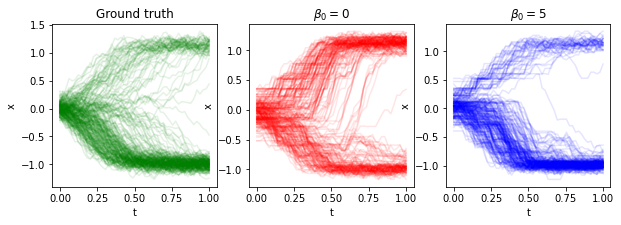

In [13]:
# plot sample paths
plt.figure(figsize = (10, 3))
plt.subplot(1, 3, 1)
plt.plot(np.linspace(0, 1, paths_gt.shape[1]), paths_gt[:, :, 0].T, color = 'green', alpha = 0.1);
plt.xlabel("t"); plt.ylabel("x")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.plot(np.linspace(0, 1, paths_nullgrowth.shape[1]), paths_nullgrowth[:, :, 0].T, color = 'red', alpha = 0.1);
plt.xlabel("t"); plt.ylabel("x")
plt.title("$\\beta_0 = 0$")
plt.subplot(1, 3, 3)
plt.plot(np.linspace(0, 1, paths_growth.shape[1]), paths_growth[:, :, 0].T, color = 'blue', alpha = 0.1);
plt.xlabel("t"); plt.ylabel("x")
plt.title("$\\beta_0 = 5$")


In [24]:
# compute empirical W2 distance between reconstructions and ground truth
dist_w2 = {}
dist_w2['nullgrowth'] = np.sqrt(util.empirical_dist(paths_gt.reshape(-1, T*dim), paths_nullgrowth.reshape(-1, T*dim)))
dist_w2['growth'] = np.sqrt(util.empirical_dist(paths_gt.reshape(-1, T*dim), paths_growth.reshape(-1, T*dim)))

In [25]:
dist_w2

{'growth': 3.212290659278081, 'nullgrowth': 8.4472662605531}